In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from collections import deque
import random as rand
import math
import sys
import matplotlib.pyplot as plt

In [63]:
np.set_printoptions(precision=6, suppress=True)

In [64]:
dnn_model = tf.keras.models.load_model('test.h5')

In [65]:
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 10000

GAMMA = 1.2
batch_size = 1
episode_done = 2000
global eps_threshold
eps_threshold = 0

In [66]:
result = []
a = pd.read_excel("real_Result/basic.xlsx").iloc[:,1:22]
b = pd.read_excel("real_Result/basic_formula.xlsx").iloc[:,1:22]
c = pd.read_excel("real_Result/reinforce.xlsx").iloc[:,1:22]
d = pd.read_excel("real_Result/result.xlsx").iloc[:,1:22]
e = pd.read_excel("real_Result/result_not_consider.xlsx").iloc[:,1:22]
f = pd.read_excel("real_Result/ae_result.xlsx").iloc[:,1:22]
g = pd.read_excel("real_Result/dqn_result.xlsx").iloc[:,1:22]
i = pd.read_excel("real_Result/reinforce_Gan.xlsx").iloc[:,1:22]
h = pd.read_excel("real_Result/ae_gen_result.xlsx").iloc[:,1:22]
df = pd.read_excel('aug_nine_var.xlsx').iloc[:,1:22]
scaler = MinMaxScaler()
a = scaler.fit_transform(a)
b = scaler.fit_transform(b)
c = scaler.fit_transform(c)
d = scaler.fit_transform(d)
e = scaler.fit_transform(e)
f = scaler.fit_transform(f)
g = scaler.fit_transform(g)
h = scaler.fit_transform(h)
i = scaler.fit_transform(i)
df = scaler.fit_transform(df)
result.append(a)
result.append(b)
result.append(c)
result.append(d)
result.append(e)
result.append(f)
result.append(g)
result.append(h)
result.append(i)
result.append(df)


In [67]:

#df_pca = pca.transform(df)
    # df_pca = pd.DataFrame(df_pca, columns = [str(i) for i in range(0,22)])
    # df_stock = df_stock.astype(float)



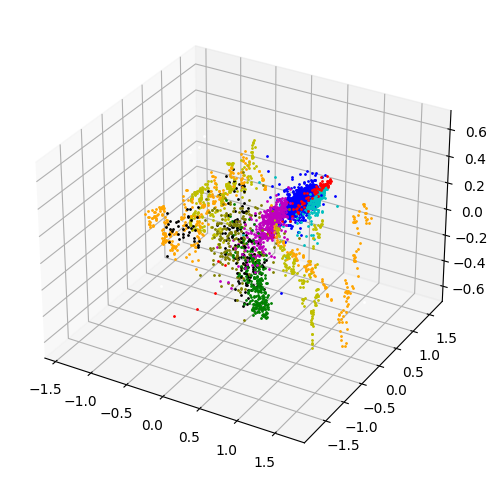

In [68]:
from sklearn.decomposition import PCA   
pca = PCA(n_components = 3)
for k in result:
    pca.fit(k)
from sklearn.cluster import KMeans
# km = KMeans(n_clusters=1, # 클러스터 개수를 사정에 지정해야하는 단점
#            init='random', # 초기중심값을 랜덤하게 설정할 것임
#            n_init=10, # 랜덤한 초기 중심점설정을 10번 다르게 잡아보고 진행하여 가장 SSE낮은 결과를 채택
#            max_iter=300, # 최대반복 수 제한
#            tol=1e-04, # 수렴 조기종료를 위한 허용오차한계
#            random_state=0)
import matplotlib.colors as colors
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
m = []
m2 = []
center_value = []
for k in result:
    km = KMeans(1)
    km.fit(k)
    m.append(pca.transform(km.cluster_centers_))
    center_value.append(km.cluster_centers_)
# colors_list = list(colors._colors_full_map.values())
colors_list = ['b','c','k','g','m','w','r','y','olive','orange']
for jr in range(len(result)):
    k = result[jr]
    ck = pca.transform(k)
    for j in ck:
        ax.scatter(j[0],j[1],j[2],c=colors_list[jr],s=1)
plt.show()


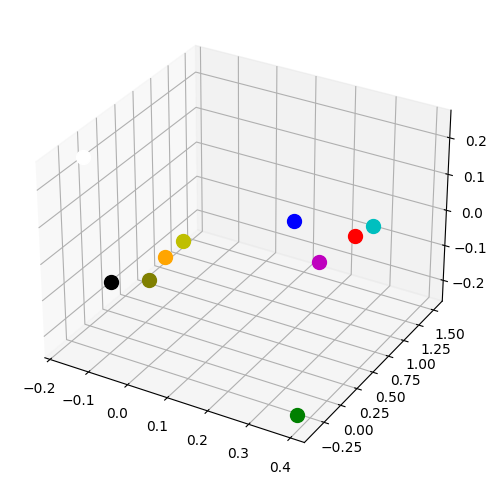

In [69]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
for j in range(len(m)):
    c = m[j][0]
    ax.scatter([c[0]],[c[1]],[c[2]],c=colors_list[j],s=100)
plt.show()

In [70]:
def return_latest():
    df = pd.read_excel('aug_nine_var.xlsx').iloc[:,1:22]
    transform = scaler.transform(df)
    return transform[-1]
def return_value():
    df = pd.read_excel('aug_nine_var.xlsx').iloc[:,22].to_numpy()
    return df[-1]

In [71]:
def return_state(action, state):
    if action % 2 == 0:
        value = -0.01
    
    else:
        value = 0.01

    j = int(action / 2)
    
    state[0][j] = state[0][j] + value
    next_state = state

    return next_state

In [102]:
# def return_reward(state, y_pred):
#     real_state = return_latest().reshape(1, 21)
#     dist = np.sqrt(np.sum(np.square(real_state-state)))

#     return dist*10 + y_pred

encoder = tf.keras.models.load_model('encoder.h5')
global c
m = []
encoder.input_shape
for j in result[-1]:
  j = encoder.predict(j.reshape((1,21,)),verbose=0)
  m.append(j.reshape(3,))
km = KMeans(1)
km.fit(m)
c = km.cluster_centers_
def return_reward(state,y_pred,destination):
  global c 
  state = np.array(state).reshape((1,21,))
  state_value = encoder.predict(state,verbose=0)
  # print(np.sum(np.square(state_value - c)),np.sum(np.square(state - destination)))
  return [[np.sum(np.square(state_value - c))+np.sum(np.square(state - destination))]]

In [ ]:
class Dqn_agent:
    def __init__(self):
        self.target = self._create_model()
        self.model = self._create_model()

        self.target.set_weights(self.model.get_weights())

        self.memory = deque(maxlen=10000)
        
    def _create_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(10, input_shape=(21, ), activation='relu'))
        model.add(tf.keras.layers.Dense(10, activation='relu'))
        model.add(tf.keras.layers.Dense(10, activation='relu'))
        model.add(tf.keras.layers.Dense(42, activation='linear'))

        model.compile(optimizer='rmsprop', loss='mse')

        return model

    def forward(self, x):
        x = self.model(x)
        return x
    
    def memorize(self, state, action, reward, next_state):
        self.memory.append((
            state, action,
            tf.cast(reward, tf.float16), next_state
        ))

    def act(self, state, episode):
        #EPS_END + ((EPS_START - EPS_END) * math.exp(-1 * episode / EPS_DECAY))
        eps_threshold = 0.3
        if(episode == 2):
            print(eps_threshold)
        if rand.random() > eps_threshold:
            return np.argmin(self.forward(state))
        else:
            return tf.convert_to_tensor([rand.randrange(42)])

    def learn(self, episode,destination):
        if len(self.memory) < batch_size:
            return
        # exit()
        if episode % 10:
            self.target.set_weights(self.model.get_weights())

        batch = rand.sample(self.memory, batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states = tf.convert_to_tensor(states[0]) # (batch_size, 21)
        actions = tf.convert_to_tensor(actions[0]) # (batch_size, )
        rewards = tf.convert_to_tensor(rewards[0]) # (batch_size, )
        next_states = tf.convert_to_tensor(next_states[0]) # (batch_size, 21)

        if actions.shape != (batch_size, ):
            actions = [actions]

        current_q = self.model.predict(states, verbose=0)
        next_q = self.target.predict(next_states, verbose=0)

        for i in range(batch_size):
            if episode == episode_done or next_states[i].numpy().tolist() == destination[0].tolist():
                next_q_value = rewards[i]
            else:
                next_q_value = rewards[i] + GAMMA * np.min(next_q[i])
            current_q[i][actions[i]] = next_q_value

        self.model.fit(states, current_q, batch_size=batch_size, verbose=False)
        

In [111]:
agent = Dqn_agent()
sc_hist = []
st_hist = []
pop_hist = []

for e in range(1, 200):
    state = return_latest()
    state = state.reshape(1, 21)
    steps = 0
    while True:
        pred_y = dnn_model.predict(state, verbose=0)
        action = agent.act(state, e)

        next_state = return_state(action, state)
        reward = return_reward(state, pred_y,center_value[0])

        agent.memorize(state, action, reward, next_state)
        agent.learn(e,center_value[0])

        state = next_state
        steps = steps + 1
        # if(steps % 10 == 0):
        print("steps: "+str(steps)+", loss: "+str(reward[0][0])+", pop: "+str(pred_y[0][0]))

        if steps == episode_done:
            print("=============episode done=============")
            print("episode: {0}, score: {1}, y_pred {2}".format(e, reward, pred_y))
            print("=======================================")
            sc_hist.append(reward)
            st_hist.append(scaler.inverse_transform(state))
            pop_hist.append(pred_y)
            break
        elif(state.tolist() == center_value[0].tolist()):
            print("=============succeed=============")
            print("episode: {0}, score: {1}, y_pred {2}".format(e, reward, pred_y))
            print("=======================================")
            sc_hist.append(reward)
            st_hist.append(scaler.inverse_transform(state))
            pop_hist.append(pred_y)


            break



steps: 1, loss: 11.717484937598533, pop: 43.886658
steps: 2, loss: 11.667790758270002, pop: 43.89521
steps: 3, loss: 11.650171729576932, pop: 43.888817
steps: 4, loss: 11.676245242422159, pop: 43.85273
steps: 5, loss: 11.70603187013349, pop: 43.859386
steps: 6, loss: 11.690942401798162, pop: 43.903885
steps: 7, loss: 11.719466790894835, pop: 43.940014
steps: 8, loss: 11.777127119329432, pop: 43.942146
steps: 9, loss: 11.759383613048747, pop: 44.016033
steps: 10, loss: 11.720518990296494, pop: 43.98082
steps: 11, loss: 11.722307606485753, pop: 43.978966
steps: 12, loss: 11.743130434366192, pop: 43.995464
steps: 13, loss: 11.684650628243247, pop: 44.01702
steps: 14, loss: 11.664890205564376, pop: 43.94314
steps: 15, loss: 11.744097591615326, pop: 43.90793
steps: 16, loss: 11.72767081749572, pop: 43.888596
steps: 17, loss: 11.786462374652762, pop: 43.879585
steps: 18, loss: 11.86707243208513, pop: 43.953453
steps: 19, loss: 11.846196935811811, pop: 43.934307
steps: 20, loss: 11.8962929881

In [ ]:
plt.plot(np.array(pop_hist).reshape(99))
plt.show()

In [ ]:
plt.plot(np.array(sc_hist).reshape(99))
plt.show()